# Basic Exploratory Data Analysis
## Prerequisites
- Install Python 3



In [55]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Disable the specific warning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
# Load Feature File
df = pd.read_csv("../TeamSeasons.csv")

## Basic Seed Exploration

In [56]:
tourney_teams = df[df['Seed'].notna()]

In [93]:
round_num_map = {
    "Play In": 0,
    "First Round": 0,
    "Second Round": 1,
    "Sweet Sixteen": 2,
    "Elite Eight": 3,
    "Final Four": 4,
    "Championship": 5,
    "Champion": 6
}
perf_map = {k: v/6 for k, v in round_num_map.items()}
tourney_teams["RoundWinsNum"] = tourney_teams["ExitRound"].map(round_num_map)
tourney_teams["Performance"] = tourney_teams["ExitRound"].map(perf_map)
tourney_teams["Performance"] = tourney_teams["Performance"].fillna(0)

In [58]:
seed_exp_perf = {
    1: 4.75, # Two lose the final four, one lose in championship, one win the championship
    2: 3, # Make the Elite Eight
    3: 2, 4: 2, # Make the Sweet Sixteen
    5: 1, 6: 1, 7: 1, 8: 1, # Make the Second Round
    9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0 # Lose the First Round
}
seed_historical_perf = {}

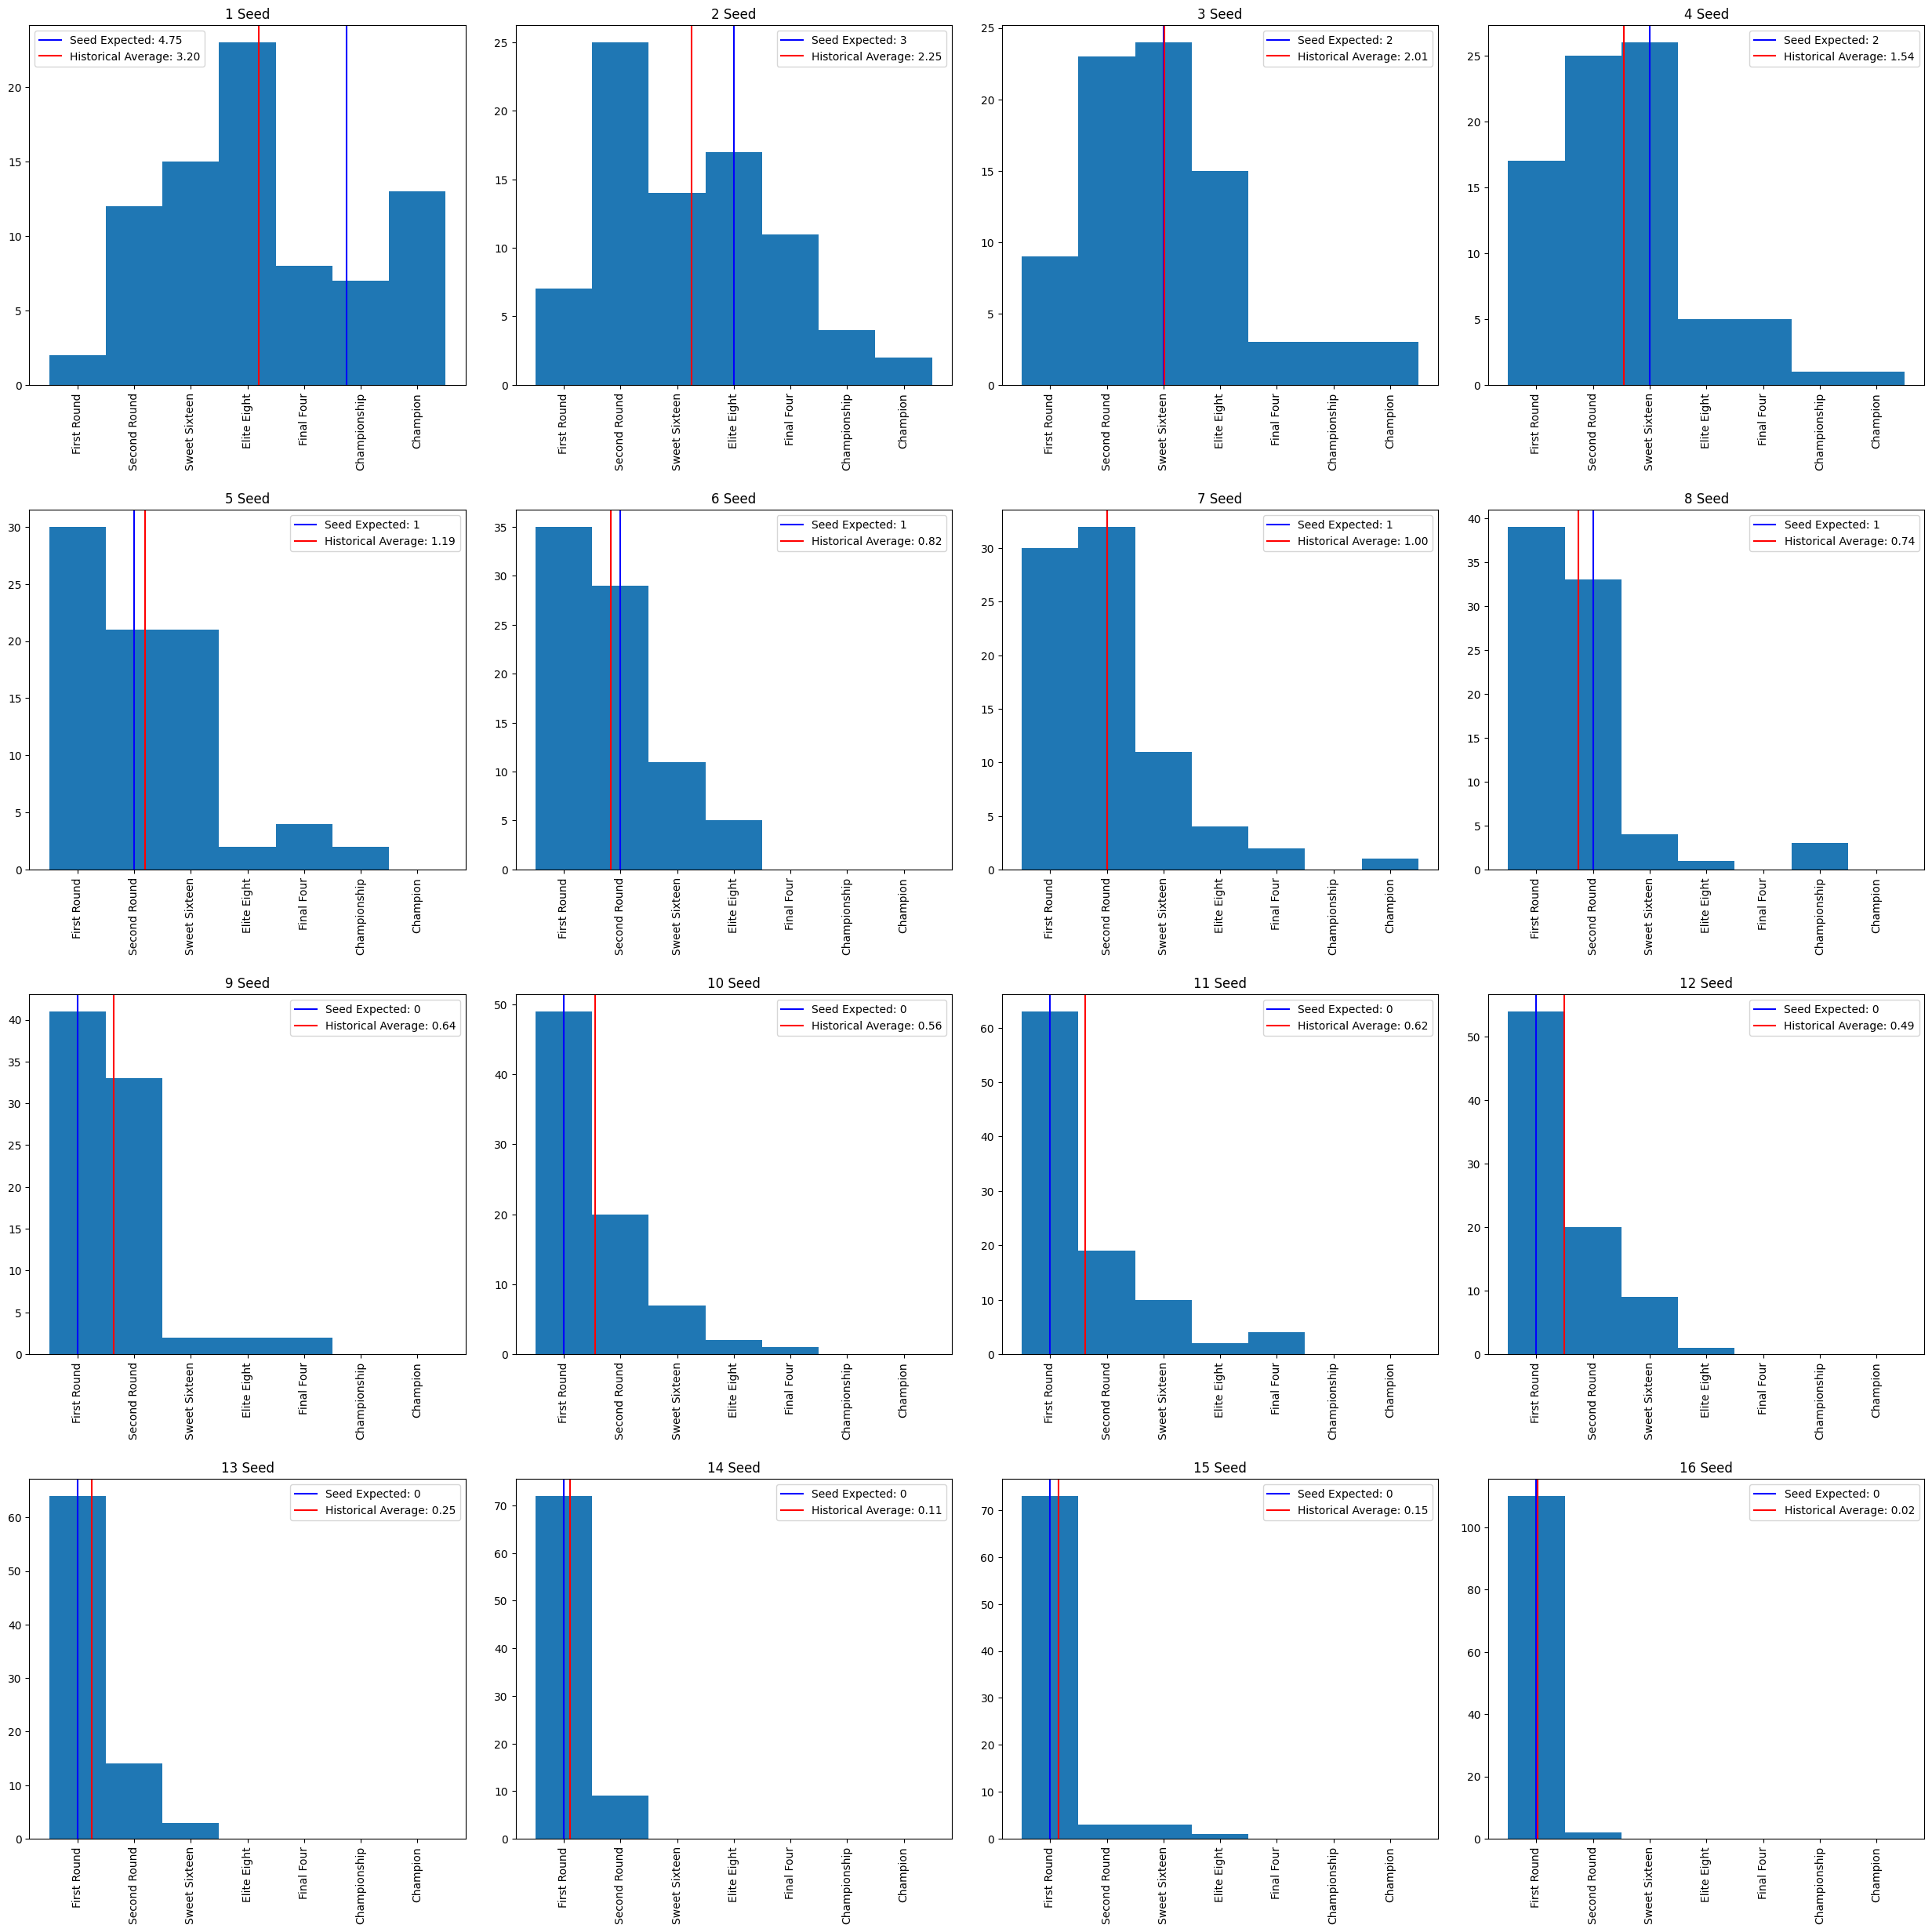

In [59]:
BIN_OFFSET = 0.5
fig, ax = plt.subplots(4, 4, figsize=(25, 25))
ax = ax.flatten()
for seed, seed_df in tourney_teams[["ExitRound", "Seed", "RoundWinsNum"]].groupby("Seed"):
    seed_axis = ax[int(seed) - 1]
    seed_df = seed_df.sort_values(["RoundWinsNum"])
    n, bins, patches = seed_axis.hist(seed_df["RoundWinsNum"], bins=range(0, 8))
    hist_avg = sum([count * rnd for count, rnd in zip(n, bins)]) / sum(n)
    seed_historical_perf[int(seed)] = hist_avg       
    seed_axis.set_title(f"{int(seed)} Seed")
    seed_axis.axvline(x = seed_exp_perf[int(seed)] + BIN_OFFSET, color = 'b', label = f'Seed Expected: {seed_exp_perf[int(seed)]}')
    seed_axis.axvline(x = hist_avg + BIN_OFFSET, color = 'r', label = f'Historical Average: {hist_avg:.2f}')
    seed_axis.set_xticks(ticks = [p._x0 + BIN_OFFSET for p in patches], labels = list(round_num_map.keys())[1:], rotation=90)
    seed_axis.legend()
fig.tight_layout(pad = 2)
plt.show()

In [60]:
tourney_teams[tourney_teams["RoundWinsNum"] > tourney_teams["Seed"].map(seed_exp_perf)][["TeamID", "Seed", "ExitRound", "RoundWinsNum", "Performance"]]

,TeamID,Seed,ExitRound,RoundWinsNum,Performance
10,1113,10.0,Second Round,1.0,0.166667
16,1120,10.0,Sweet Sixteen,2.0,0.333333
32,1139,12.0,Sweet Sixteen,2.0,0.333333
34,1141,11.0,Second Round,1.0,0.166667
55,1163,5.0,Sweet Sixteen,2.0,0.333333
...,...,...,...,...,...
7061,1277,7.0,Sweet Sixteen,2.0,0.333333
7117,1336,10.0,Second Round,1.0,0.166667
7119,1338,11.0,Second Round,1.0,0.166667
7124,1343,15.0,Sweet Sixteen,2.0,0.333333


In [61]:
tourney_teams["ExceedExp"] = tourney_teams["RoundWinsNum"] > tourney_teams["Seed"].map(seed_exp_perf)

In [62]:
tourney_teams[["TeamID", "Seed", "ExitRound", "RoundWinsNum", "Performance", "ExceedExp"]].head(5)

,TeamID,Seed,ExitRound,RoundWinsNum,Performance,ExceedExp
2,1104,10.0,First Round,0.0,0.000000,False
9,1112,1.0,Elite Eight,3.0,0.500000,False
10,1113,10.0,Second Round,1.0,0.166667,True
16,1120,10.0,Sweet Sixteen,2.0,0.333333,True
17,1122,13.0,First Round,0.0,0.000000,False


/var/folders/7y/1jp5fzbs05q03xszr7zmwvqw0000gn/T/ipykernel_82129/2227986977.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=range(1, 17), label="Seed")


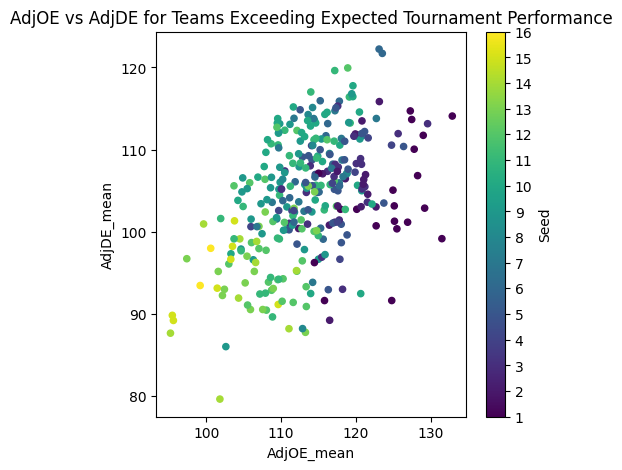

In [63]:
exceed_exp_df = tourney_teams[tourney_teams["ExceedExp"]]
# Color by seed
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(1, 16)
exceed_exp_df["color"] = exceed_exp_df["Seed"].apply(lambda x: cmap(norm(x)))
exceed_exp_df.plot(kind='scatter', x='AdjOE_mean', y='AdjDE_mean', c='color', figsize=(5, 5))
plt.title("AdjOE vs AdjDE for Teams Exceeding Expected Tournament Performance")
# Configure legend for the cmap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=range(1, 17), label="Seed")
plt.show()

# Investigate Individual Feature Importance

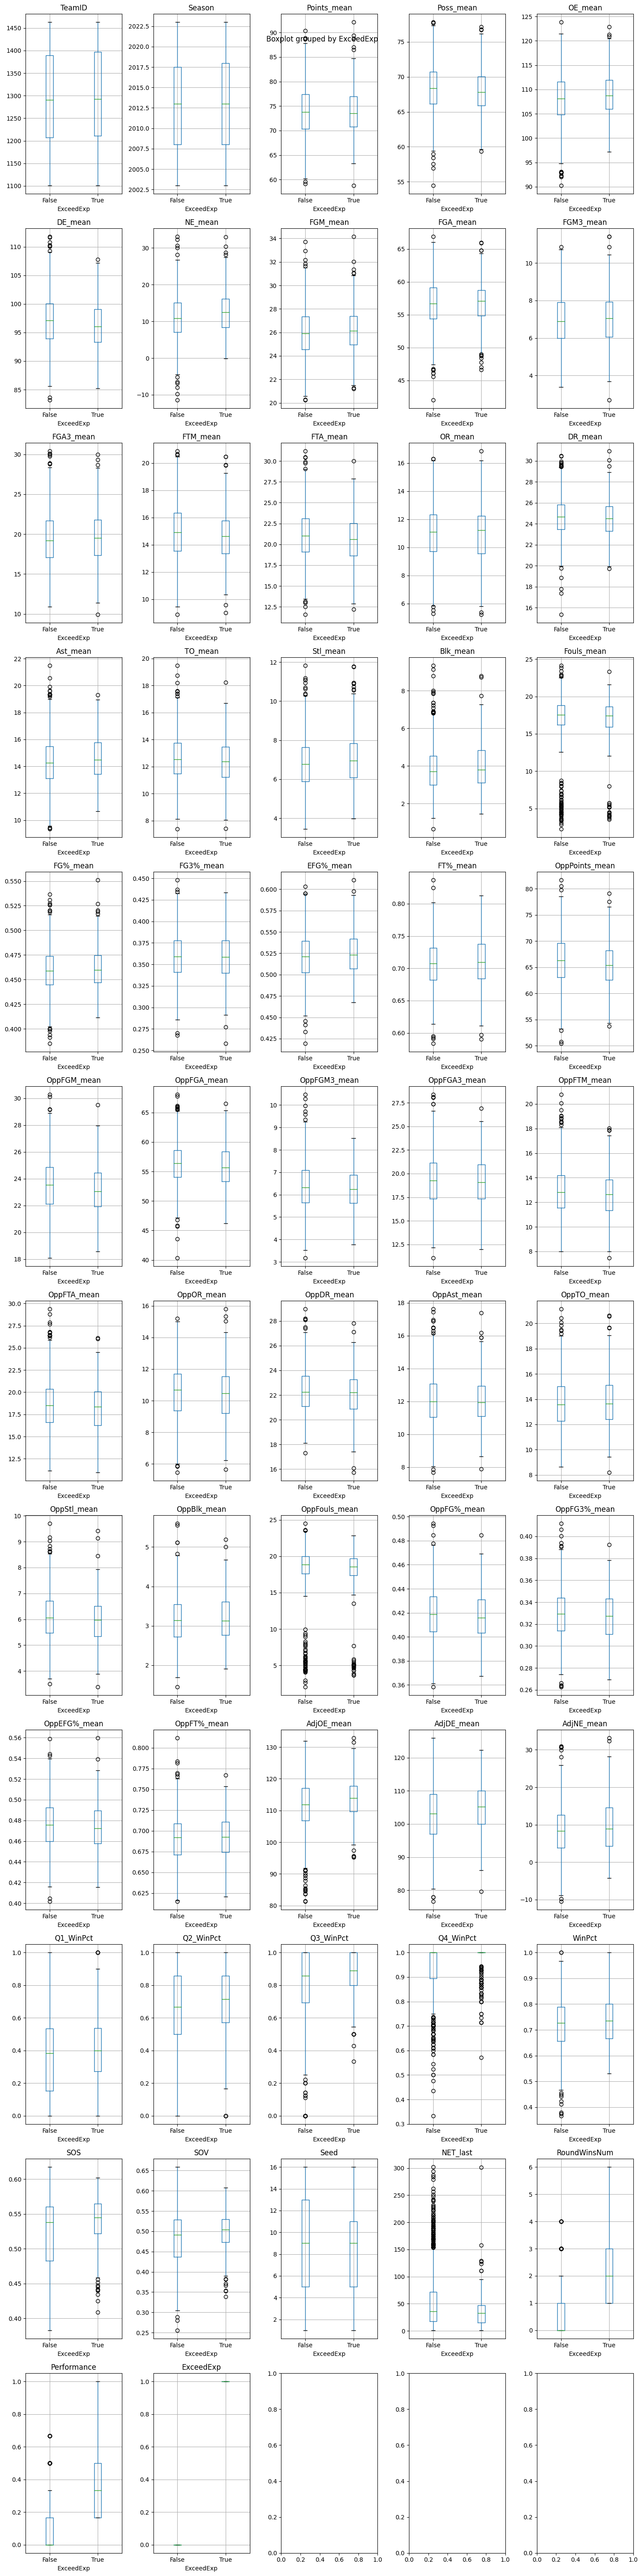

In [64]:
import math
filtered_columns = [col for col in tourney_teams.columns if not col.endswith("_stdev") and col != "ExitRound"]
rows = math.ceil(len(filtered_columns) / 5)
fig, ax = plt.subplots(nrows=rows, ncols=5, figsize=(15, 5*rows))
ax = ax.flatten().tolist()
for i, col in enumerate(filtered_columns):
    try:
        tourney_teams.boxplot(column = col, by = "ExceedExp", ax = ax[i])
        ax[i].set_title(col)
    except IndexError:
        print(f"IndexError: {i} {col}")
fig.tight_layout()
plt.show()

In [65]:
# Import HDBSCAN
from sklearn.cluster import HDBSCAN

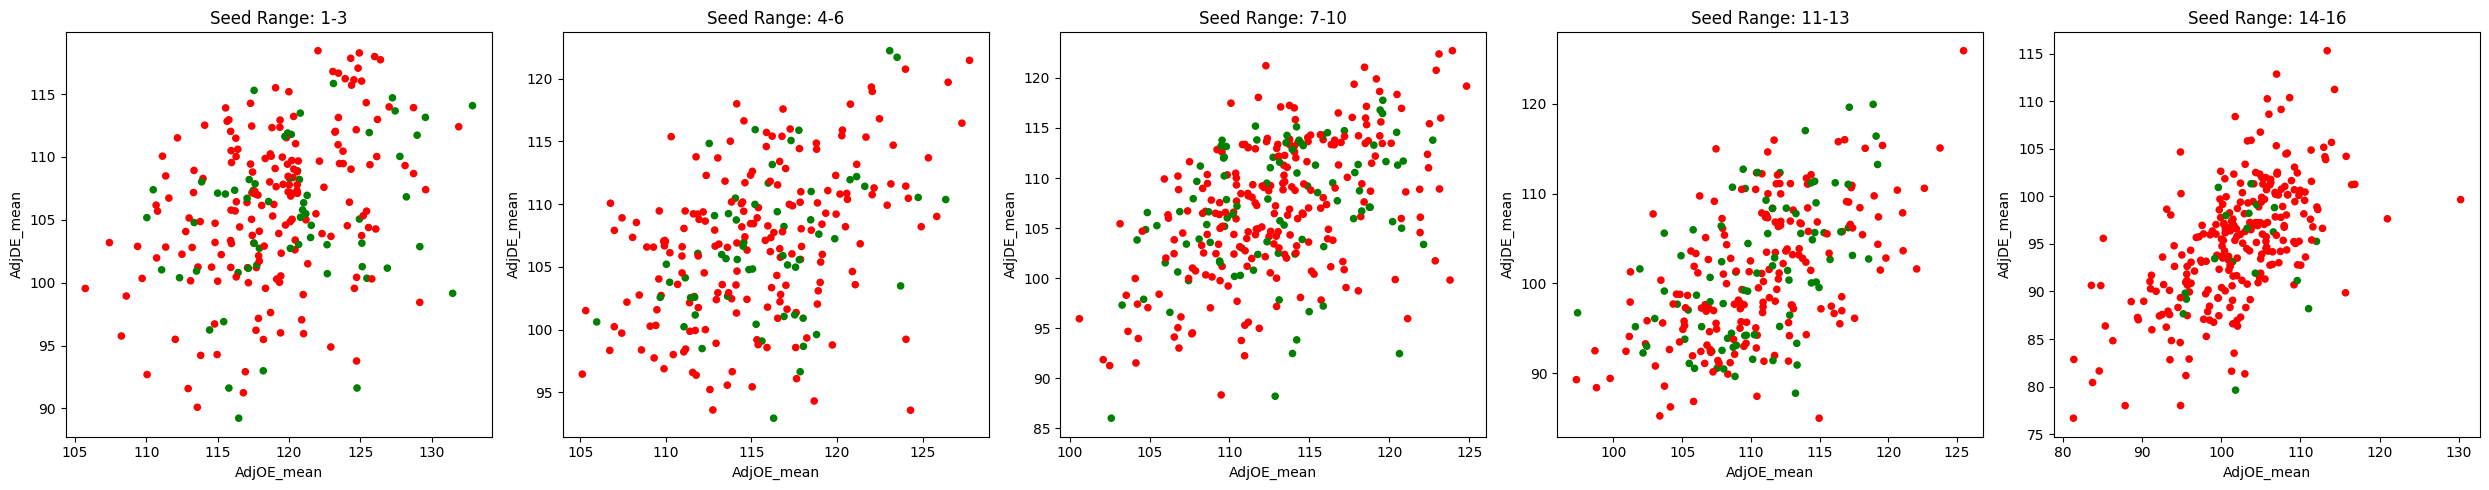

In [66]:
seed_bounds = [(1, 3), (4, 6), (7, 10), (11, 13), (14, 16)]
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
ax = ax.flatten()
for i, (lower, upper) in enumerate(seed_bounds):
    ax[i].set_title(f"Seed Range: {lower}-{upper}")
    seed_df = tourney_teams[(tourney_teams["Seed"] >= lower) & (tourney_teams["Seed"] <= upper)]
    colors = seed_df["ExceedExp"].map({True: "g", False: "r"})
    # Scatter plot of AdjOE vs AdjDE with color by ExceedExpColor
    seed_df.plot(kind='scatter', x='AdjOE_mean', y='AdjDE_mean', c=colors, ax=ax[i])
    
    # Run HDBScan on the data
    hdb = HDBSCAN(min_cluster_size=20)
    # Plot the clusters
    hdb.fit(seed_df[["AdjOE_mean", "AdjDE_mean"]])
fig.tight_layout()



# Setup Datasets for Model Exploration

In [67]:
tourney_teams["ExceedExp"].value_counts()

False    1023
True      313
Name: ExceedExp, dtype: int64

In [80]:
X_COLS = set(tourney_teams.columns.tolist()) - { "ExceedExp", "ExitRound", "RoundWinsNum", "Performance", "Seed" }

In [69]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = tourney_teams[list(X_COLS)]
X.fillna(0, inplace=True)
Y = tourney_teams["ExceedExp"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, stratify=Y, shuffle=True)
ss_train = MinMaxScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = MinMaxScaler()
X_test = ss_test.fit_transform(X_test)

# Methods for Feature Selection

In [70]:
SELECT_N_FEATURES = 12

In [71]:
# Basic Feature Selection for Classification
from sklearn.feature_selection import SelectKBest, f_classif

cls_selector = SelectKBest(f_classif, k=SELECT_N_FEATURES)
X_train_selected = cls_selector.fit_transform(X_train, Y_train)
X_test_selected = cls_selector.transform(X_test)

selected_features = X.columns[cls_selector.get_support()]
selected_features

Index(['DE_mean', 'Q3_WinPct', 'AdjNE_stdev', 'SOV', 'NE_mean', 'NET_last',
       'AdjOE_mean', 'OppPoints_mean', 'SOS', 'FTA_mean', 'Q2_WinPct',
       'Q4_WinPct'],
      dtype='object')

In [72]:
# Feature Selection for Regression
from sklearn.feature_selection import SelectKBest, f_regression

reg_selector = SelectKBest(f_regression, k=SELECT_N_FEATURES)
X_train_selected = reg_selector.fit_transform(X_train, Y_train)
X_test_selected = reg_selector.transform(X_test)

selected_features = X.columns[reg_selector.get_support()]
selected_features

Index(['DE_mean', 'Q3_WinPct', 'AdjNE_stdev', 'SOV', 'NE_mean', 'NET_last',
       'AdjOE_mean', 'OppPoints_mean', 'SOS', 'FTA_mean', 'Q2_WinPct',
       'Q4_WinPct'],
      dtype='object')

In [73]:
# L1-based Feature Selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.025, penalty="l1", dual=False, max_iter=10000).fit(X_train, Y_train)
model = SelectFromModel(lsvc, prefit=True)
X_train_selected = model.transform(X_train)

selected_features = X.columns[model.get_support()]
selected_features

Index(['OppFouls_mean', 'NET_last', 'FTM_mean', 'OppPoints_mean', 'FTA_mean'], dtype='object')

In [74]:
# Tree-based Feature Selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train, Y_train)
model = SelectFromModel(clf, prefit=True)
X_train_selected = model.transform(X_train)

selected_features = X.columns[model.get_support()]
selected_features

Index(['OppFTM_mean', 'OppTO_mean', 'OppTO_stdev', 'Q1_WinPct', 'Q3_WinPct',
       'OppFG3%_mean', 'FT%_stdev', 'AdjNE_stdev', 'OR_stdev', 'AdjNE_mean',
       'Blk_stdev', 'FGA3_mean', 'SOV', 'Ast_mean', 'OppFGA_mean', 'FTM_stdev',
       'OppBlk_mean', 'EFG%_mean', 'FGM3_mean', 'OppFG3%_stdev',
       'OppFGA_stdev', 'Poss_mean', 'OppFTA_stdev', 'NE_mean', 'OppOR_stdev',
       'AdjDE_mean', 'NET_last', 'OppFTA_mean', 'FTM_mean', 'FG%_stdev',
       'Poss_stdev', 'FTA_stdev', 'TO_stdev', 'OppFG%_stdev', 'SOS',
       'FT%_mean', 'Stl_stdev', 'OppFT%_stdev', 'FGM_stdev', 'OppEFG%_stdev',
       'OppPoints_stdev', 'Stl_mean', 'FTA_mean', 'OppFGM_mean', 'Q2_WinPct',
       'AdjOE_stdev', 'DR_mean', 'OppEFG%_mean', 'OppBlk_stdev'],
      dtype='object')

In [75]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import xgboost as xgb

models = {
    "Logistic Reg": LogisticRegression(),
    "Ridge": RidgeClassifier(alpha=0.5),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(kernel="poly", degree=3, C=0.1, gamma="auto", max_iter=100000000),
    "LinearSVC": LinearSVC(max_iter=1000000),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": xgb.XGBClassifier()
}
model_res = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall"])
for model_name, model in models.items():
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    model_res = model_res.append({
        "Model": model_name,
        "Accuracy":  accuracy_score(predictions, Y_test),
        "Precision": precision_score(predictions, Y_test),
        "Recall":    recall_score(predictions, Y_test, zero_division="warn")
    }, ignore_index=True)
print(model_res)


/Users/andrewgrowney/.pyenv/versions/3.9.10/envs/nlu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


           Model  Accuracy  Precision    Recall
0   Logistic Reg  0.751244   0.000000  0.000000
1          Ridge  0.766169   0.021277  0.500000
2  Random Forest  0.756219   0.063830  0.375000
3            SVM  0.766169   0.000000  0.000000
4      LinearSVC  0.761194   0.021277  0.333333
5    Naive Bayes  0.626866   0.574468  0.329268
6            KNN  0.711443   0.085106  0.210526
7  Decision Tree  0.572139   0.234043  0.180328
8        XGBoost  0.741294   0.063830  0.272727


# Naive Bayes Feature Importance

In [76]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(models["Naive Bayes"], X_test, Y_test)

nb_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": imps.importances_mean,
    "Std": imps.importances_std
})
nb_importances = nb_importances.sort_values("Importance", ascending=False)
nb_importances

,Feature,Importance,Std
50,FG%_stdev,9.950249e-04,0.005802
45,OppFGM3_stdev,2.220446e-17,0.003147
5,FG3%_stdev,0.000000e+00,0.000000
82,EFG%_stdev,0.000000e+00,0.000000
20,Blk_stdev,-9.950249e-04,0.005802
...,...,...,...
25,Ast_mean,-1.890547e-02,0.007312
51,OppStl_stdev,-1.890547e-02,0.010147
92,Q4_WinPct,-1.990050e-02,0.010436
38,NE_mean,-2.487562e-02,0.009950


## Looking at XGB Boost Feature Importance

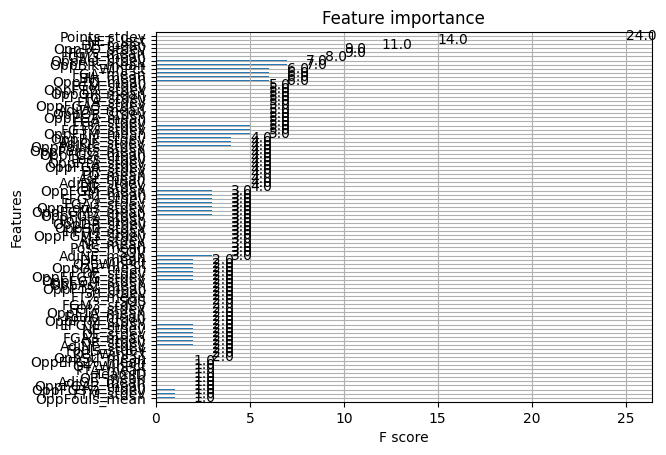

In [77]:
# XGBoost Feature Importance
dtrain = xgb.DMatrix(X_train, label=Y_train, feature_names=X.columns.tolist())
xgb.plot_importance(xgb.train({}, dtrain))
plt.show()

# Predicting Exit Round with Different Basic Regression Models

In [94]:
# Scale features per column
X_scaled = StandardScaler().fit_transform(X)
# Performance
Y_sern = tourney_teams["Performance"]


In [99]:
X.describe()

,Points_stdev,FG%_mean,OppStl_mean,DE_mean,OppFTM_mean,FG3%_stdev,OppTO_mean,OppTO_stdev,Q1_WinPct,Blk_mean,...,OppFGM_mean,Q2_WinPct,FG3%_mean,AdjOE_stdev,OE_mean,DR_mean,Q4_WinPct,Season,OppEFG%_mean,OppBlk_stdev
count,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,...,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000
mean,11.002145,0.459971,6.075030,96.858434,12.852897,0.111838,13.707844,3.879468,0.362858,3.858826,...,23.447562,0.637806,0.358985,16.647872,108.285556,24.657265,0.944946,2012.760479,0.475251,2.096800
std,1.672527,0.022117,0.919795,4.430160,2.014863,0.017922,2.025227,0.676209,0.246140,1.174227,...,1.956808,0.292439,0.026791,2.400830,4.910225,1.856078,0.102179,5.984459,0.023882,0.378453
min,6.208651,0.385235,3.387097,83.201102,7.470588,0.061564,8.200000,2.034426,0.000000,0.655172,...,18.093750,0.000000,0.258129,9.315979,90.270663,15.357143,0.000000,2003.000000,0.401829,1.178834
25%,9.800214,0.445446,5.443627,93.838177,11.500000,0.099187,12.281250,3.392586,0.200000,3.000000,...,22.064012,0.500000,0.340387,14.975012,105.033561,23.453812,0.909091,2008.000000,0.459364,1.831978
50%,10.986104,0.459117,6.033333,96.919838,12.777722,0.110593,13.599905,3.826871,0.384615,3.750000,...,23.406897,0.666667,0.358990,16.536415,108.263480,24.596875,1.000000,2013.000000,0.475085,2.067964
75%,12.074119,0.474170,6.666667,99.860112,14.157510,0.123603,15.000000,4.278875,0.533333,4.601515,...,24.782366,0.857143,0.377772,18.209223,111.675132,25.819519,1.000000,2018.000000,0.491719,2.342508
max,17.024311,0.551026,9.700000,111.763951,20.766667,0.181762,21.137931,7.342480,1.000000,9.333333,...,30.272727,1.000000,0.447983,26.573453,123.829359,30.939394,1.000000,2023.000000,0.559616,3.458949


In [98]:
Y_sern.describe()

count    1336.000000
mean        0.157186
std         0.221206
min         0.000000
25%         0.000000
50%         0.000000
75%         0.166667
max         1.000000
Name: Performance, dtype: float64

In [96]:
# Predict ExitRoundNum with XGBoost
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold

reg_models = [
    ("XGBReg", XGBRegressor()),
    ("linear", LinearRegression()),
    ("SGD", SGDRegressor())
]
reg_model_res = pd.DataFrame(columns=["Model", "MAE", "MAE_std"])
for model_name, model in reg_models:
    score = cross_val_score(model, X_scaled, Y_sern, cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1))
    reg_model_res = reg_model_res.append({
        "Model": model_name,
        "MAE": score.mean(),
        "MAE_std": score.std()
    }, ignore_index=True)
reg_model_res

,Model,MAE,MAE_std
0,XGBReg,0.237571,0.129350
1,linear,0.264306,0.086817
2,SGD,0.273011,0.073361
